# Odpady w tonach rok 2023

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import matplotlib.patheffects as path_effects
from scipy.interpolate import griddata

# Wczytanie pliku SHP z danymi geograficznymi powiatów
powiaty = gpd.read_file("powiaty.shp")

# Wczytanie pliku CSV z danymi atrybutowymi powiatów
danePow2023 = pd.read_csv("powiat2023.csv")

# Normalizacja nazw powiatów w obu zbiorach danych
powiaty['JPT_NAZWA_'] = powiaty['JPT_NAZWA_'].str.replace('powiat ', '', regex=False)
powiaty['powiat'] = powiaty['JPT_NAZWA_'].str.strip().str.lower()
danePow2023['powiat'] = danePow2023['powiat'].str.strip().str.lower()

# Połączenie danych geograficznych z atrybutowymi na podstawie nazwy powiatu
powiaty2 = powiaty.merge(danePow2023, on='powiat')


In [ ]:
print(powiaty2.head())

  gml_id JPT_SJR_KO JPT_POWIER JPT_KOD_JE   JPT_NAZWA_ JPT_ORGAN_ JPT_JOR_ID  \
0   None        POW      92617       1807  krośnieński       None      13415   
1   None        POW      92617       1807  krośnieński       None      13415   
2   None        POW     141297       2804     elbląski       None      13422   
3   None        POW     209827       1415   ostrołęcki       None      13409   
4   None        POW      79097       0413   sępoleński       None      13424   

  WERSJA_OD WERSJA_DO  WAZNY_OD  ...       powiat  oid      kod KTS  \
0  20210128         0  20170101  ...  krośnieński   79  20811402000   
1  20210128         0  20170101  ...  krośnieński  198  61813307000   
2  20210514         0  20120926  ...     elbląski  307  42815404000   
3  20210518         0  20120926  ...   ostrołęcki  152  71422615000   
4  20220112         0  20120926  ...   sępoleński   43  40416813000   

  powierzchnia   rok TERYT Typ powiatu TERYT województwa          Województwo  \
0       139

In [ ]:
# Obliczenie centroidów dla każdego powiatu
powiaty2['centroid'] = powiaty2.geometry.centroid

In [ ]:
powiaty2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 48 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gml_id                              0 non-null      object  
 1   JPT_SJR_KO                          400 non-null    object  
 2   JPT_POWIER                          400 non-null    object  
 3   JPT_KOD_JE                          400 non-null    object  
 4   JPT_NAZWA_                          400 non-null    object  
 5   JPT_ORGAN_                          0 non-null      object  
 6   JPT_JOR_ID                          400 non-null    object  
 7   WERSJA_OD                           400 non-null    object  
 8   WERSJA_DO                           400 non-null    object  
 9   WAZNY_OD                            400 non-null    object  
 10  WAZNY_DO                            400 non-null    object  
 11  JPT_KOD__1              

In [ ]:
# Funkcja do obliczania odległości w kilometrach
def haversine(point1, point2):
    lon1, lat1 = point1.x, point1.y
    lon2, lat2 = point2.x, point2.y
    # Promień Ziemi w kilometrach
    R = 6371.0
    # Konwersja stopni na radiany
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    # Obliczanie odległości
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Inicjalizacja macierzy odległości
num_powiaty = len(powiaty2)
distance_matrix = np.zeros((num_powiaty, num_powiaty))

# Wypełnienie macierzy odległości
for i, centroid_i in enumerate(powiaty2['centroid']):
    for j, centroid_j in enumerate(powiaty2['centroid']):
        if i != j:
            distance_matrix[i, j] = haversine(centroid_i, centroid_j)
        else:
            distance_matrix[i, j] = 1  # Odległość do samego siebie


In [ ]:
def calculate_potential(masses, distances, beta=1):
    potentials = np.zeros(len(masses))
    avg_distance = np.mean(distances[distances > 0])  # Średnia odległość dla wartości > 0

    for i in range(len(masses)):
        adjusted_distances = distances[i].copy()
        adjusted_distances[adjusted_distances == 0] = avg_distance
        potentials[i] = np.sum(masses / (adjusted_distances ** beta))
    return potentials

In [ ]:
masses = powiaty2['Odpady zebrane w ciągu roku|ogółem'].values

# Obliczenie potencjału dla każdego powiatu
beta = 1  # Parametr modelu
powiaty2['potential'] = calculate_potential(masses, distance_matrix, beta)


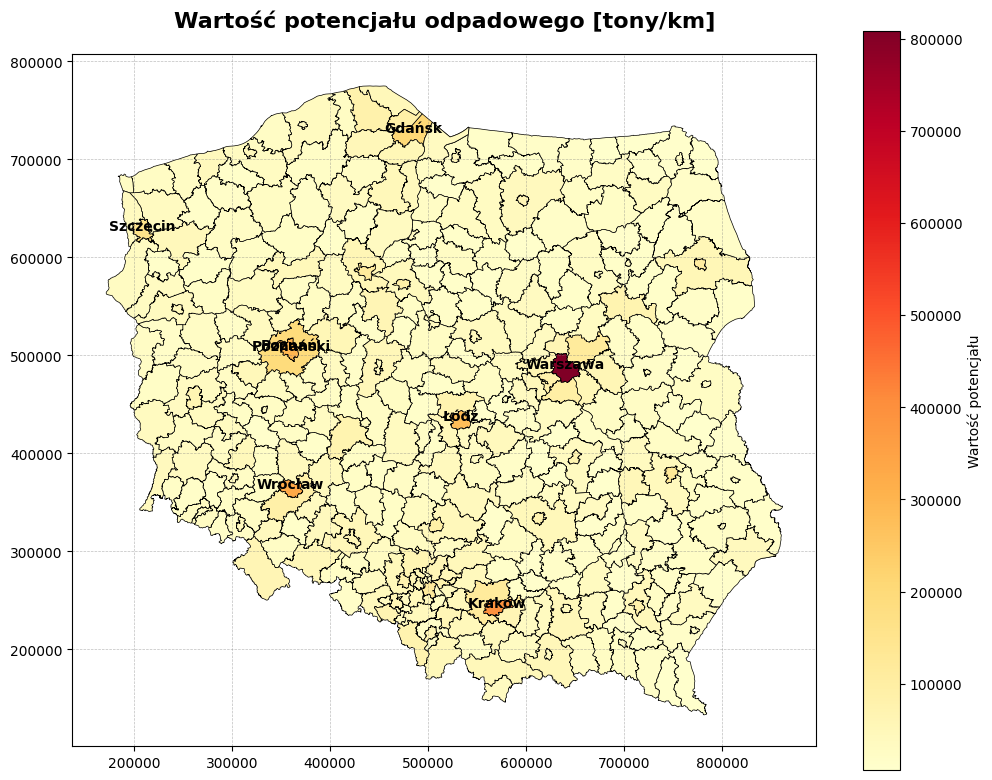

In [ ]:
# Utworzenie mapy z potencjałem
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
high_potential_threshold = np.percentile(powiaty2['potential'], 98)

# Rysowanie mapy
powiaty2.plot(
    column='potential',
    cmap='YlOrRd',  # Kontrastowa paleta kolorów
    linewidth=0.5,
    ax=ax,
    edgecolor='black',  # Dodanie wyraźnych granic powiatów
    legend=True,
    legend_kwds={
        'label': "Wartość potencjału",
        'orientation': "vertical",
        'shrink': 0.8,  # Dostosowanie rozmiaru legendy
    },
)

# Dodanie tytułu
plt.title('Wartość potencjału odpadowego [tony/km]', fontsize=16, fontweight='bold', pad=20)

# Dodanie siatki
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Dodanie etykiet tylko dla powiatów o wysokim potencjale
for x, y, label, name in zip(
    powiaty2.centroid.x,
    powiaty2.centroid.y,
    powiaty2['potential'],
    powiaty2['powiat'].str.title()
):
    if label > high_potential_threshold:  # Warunek na dużą wartość potencjału
        ax.text(x, y, name, fontsize=10, ha='center', color='black', fontweight='bold')


plt.show()


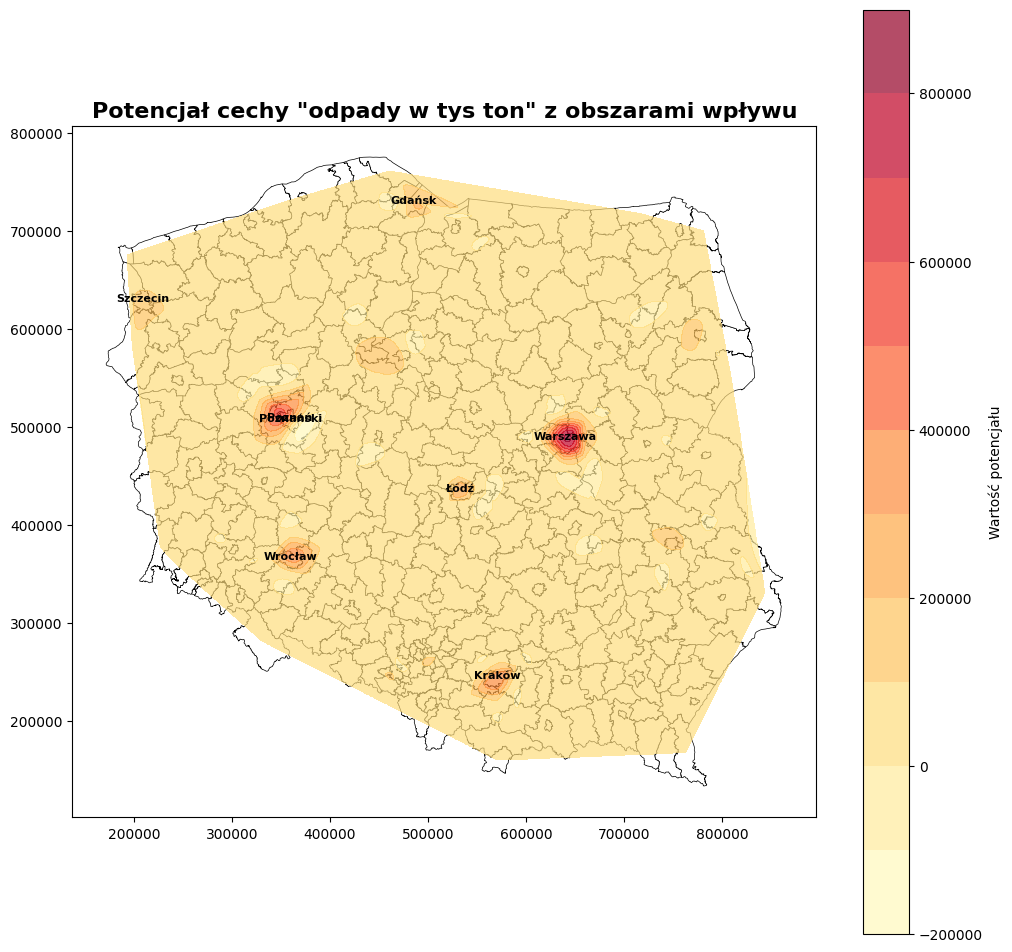

In [ ]:
potential = powiaty2['potential'].values
powiaty2['x'] = powiaty2.centroid.x
powiaty2['y'] = powiaty2.centroid.y
x = powiaty2['x'].values
y = powiaty2['y'].values

# Tworzenie siatki (grid) dla obszarów wpływu
xi, yi = np.linspace(x.min(), x.max(), 2000), np.linspace(y.min(), y.max(), 2000)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), potential, (xi, yi), method='cubic')

# Rysowanie mapy z obszarami wpływu
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
powiaty.plot(ax=ax, edgecolor='black', color='white', linewidth=0.5)  # Granice powiatów

# Dodanie obszarów wpływu (konturów)
contour = ax.contourf(xi, yi, zi, levels=10, cmap='YlOrRd', alpha=0.7)

# Dodanie legendy dla obszarów wpływu
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Wartość potencjału")

# Dodanie nazw powiatów o wysokim potencjale
high_potential_threshold = np.percentile(potential, 98)
for px, py, pval, pname in zip(x, y, potential, powiaty2['powiat'].str.title()):
    if pval > high_potential_threshold:
        ax.text(px, py, pname, fontsize=8, ha='center', color='black', fontweight='bold')

# Tytuł mapy
plt.title('Potencjał cechy "odpady w tys ton" z obszarami wpływu', fontsize=16, fontweight='bold')
plt.show()

# Odpady w tonach rok 2003

In [ ]:
# Wczytanie pliku SHP z danymi geograficznymi powiatów
powiaty = gpd.read_file("powiaty.shp")

# Wczytanie pliku CSV z danymi atrybutowymi powiatów
danePow2003 = pd.read_csv("powiat2003.csv")

# Normalizacja nazw powiatów w obu zbiorach danych
powiaty['JPT_NAZWA_'] = powiaty['JPT_NAZWA_'].str.replace('powiat ', '', regex=False)
powiaty['powiat'] = powiaty['JPT_NAZWA_'].str.strip().str.lower()
danePow2003['powiat'] = danePow2003['powiat'].str.strip().str.lower()

# Połączenie danych geograficznych z atrybutowymi na podstawie nazwy powiatu
powiaty3 = powiaty.merge(danePow2003, on='powiat')


In [ ]:
print(powiaty3.head())

  gml_id JPT_SJR_KO JPT_POWIER JPT_KOD_JE   JPT_NAZWA_ JPT_ORGAN_ JPT_JOR_ID  \
0   None        POW      92617       1807  krośnieński       None      13415   
1   None        POW      92617       1807  krośnieński       None      13415   
2   None        POW     141297       2804     elbląski       None      13422   
3   None        POW     209827       1415   ostrołęcki       None      13409   
4   None        POW      79097       0413   sępoleński       None      13424   

  WERSJA_OD WERSJA_DO  WAZNY_OD  ...       powiat  oid      kod KTS  \
0  20210128         0  20170101  ...  krośnieński  109  20811402000   
1  20210128         0  20170101  ...  krośnieński  304  61813307000   
2  20210514         0  20120926  ...     elbląski  229  42815404000   
3  20210518         0  20120926  ...   ostrołęcki   39  71422615000   
4  20220112         0  20120926  ...   sępoleński  211  40416813000   

  powierzchnia   rok TERYT Typ powiatu TERYT województwa          Województwo  \
0       139

In [ ]:
# Obliczenie centroidów dla każdego powiatu
powiaty3['centroid'] = powiaty3.geometry.centroid

In [ ]:
powiaty3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 48 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gml_id                              0 non-null      object  
 1   JPT_SJR_KO                          398 non-null    object  
 2   JPT_POWIER                          398 non-null    object  
 3   JPT_KOD_JE                          398 non-null    object  
 4   JPT_NAZWA_                          398 non-null    object  
 5   JPT_ORGAN_                          0 non-null      object  
 6   JPT_JOR_ID                          398 non-null    object  
 7   WERSJA_OD                           398 non-null    object  
 8   WERSJA_DO                           398 non-null    object  
 9   WAZNY_OD                            398 non-null    object  
 10  WAZNY_DO                            398 non-null    object  
 11  JPT_KOD__1              

In [ ]:
# Funkcja do obliczania odległości w kilometrach
def haversine(point1, point2):
    lon1, lat1 = point1.x, point1.y
    lon2, lat2 = point2.x, point2.y
    # Promień Ziemi w kilometrach
    R = 6371.0
    # Konwersja stopni na radiany
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    # Obliczanie odległości
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Inicjalizacja macierzy odległości
num_powiaty = len(powiaty3)
distance_matrix = np.zeros((num_powiaty, num_powiaty))

# Wypełnienie macierzy odległości
for i, centroid_i in enumerate(powiaty3['centroid']):
    for j, centroid_j in enumerate(powiaty3['centroid']):
        if i != j:
            distance_matrix[i, j] = haversine(centroid_i, centroid_j)
        else:
            distance_matrix[i, j] = 1  # Odległość do samego siebie


In [ ]:
def calculate_potential(masses, distances, beta=1):
    potentials = np.zeros(len(masses))
    avg_distance = np.mean(distances[distances > 0])  # Średnia odległość dla wartości > 0

    for i in range(len(masses)):
        adjusted_distances = distances[i].copy()
        adjusted_distances[adjusted_distances == 0] = avg_distance
        potentials[i] = np.sum(masses / (adjusted_distances ** beta))
    return potentials

In [ ]:
masses = powiaty3['Odpady zebrane w ciągu roku|ogółem'].values

# Obliczenie potencjału dla każdego powiatu
beta = 1  # Parametr modelu
powiaty3['potential'] = calculate_potential(masses, distance_matrix, beta)


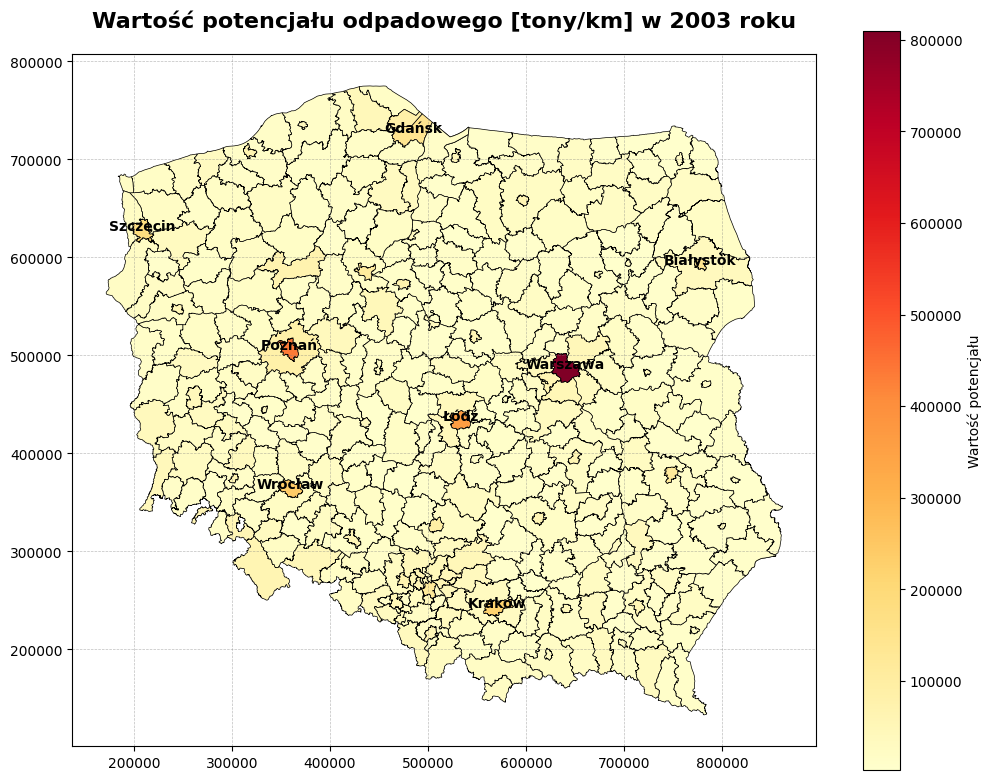

In [ ]:
# Utworzenie mapy z potencjałem
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
high_potential_threshold = np.percentile(powiaty3['potential'], 98)

# Rysowanie mapy
powiaty3.plot(
    column='potential',
    cmap='YlOrRd',  # Kontrastowa paleta kolorów
    linewidth=0.5,
    ax=ax,
    edgecolor='black',  # Dodanie wyraźnych granic powiatów
    legend=True,
    legend_kwds={
        'label': "Wartość potencjału",
        'orientation': "vertical",
        'shrink': 0.8,  # Dostosowanie rozmiaru legendy
    },
)

# Dodanie tytułu
plt.title('Wartość potencjału odpadowego [tony/km] w 2003 roku', fontsize=16, fontweight='bold', pad=20)

# Dodanie siatki
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Dodanie etykiet tylko dla powiatów o wysokim potencjale
for x, y, label, name in zip(
    powiaty3.centroid.x,
    powiaty3.centroid.y,
    powiaty3['potential'],
    powiaty3['powiat'].str.title()
):
    if label > high_potential_threshold:  # Warunek na dużą wartość potencjału
        ax.text(x, y, name, fontsize=10, ha='center', color='black', fontweight='bold')


plt.show()


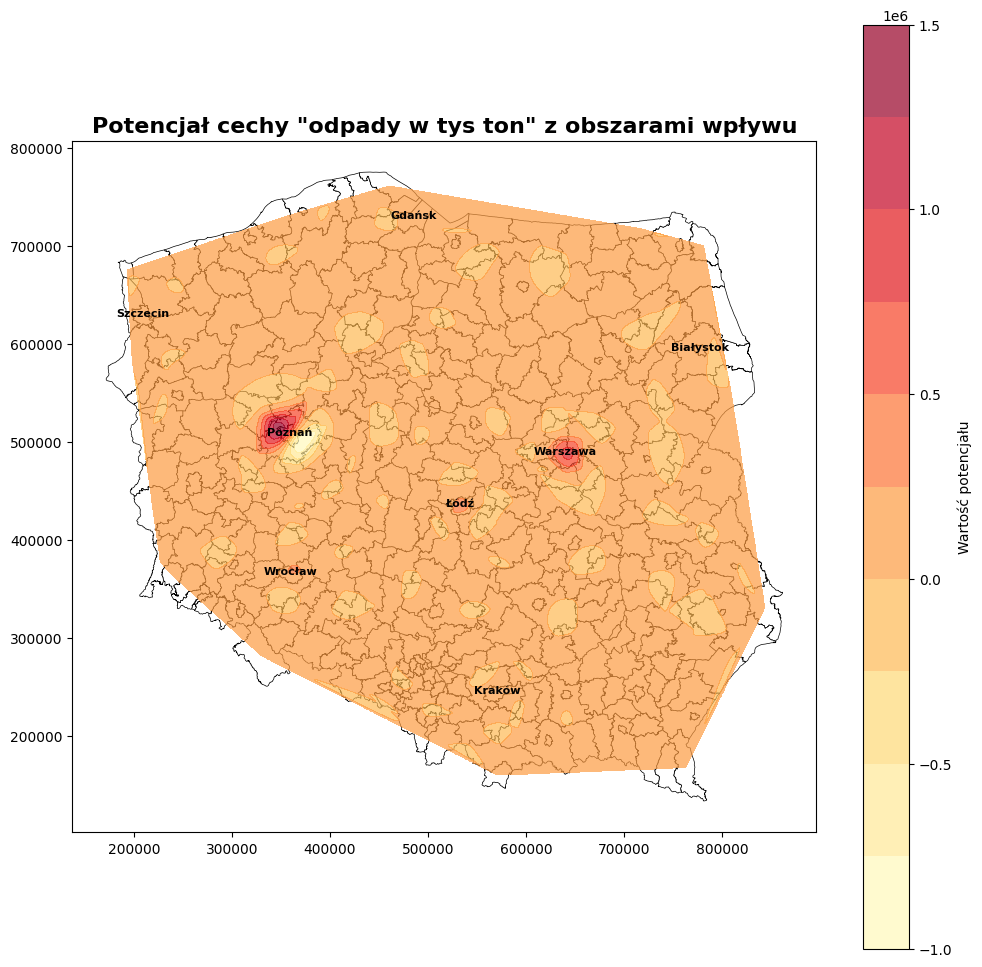

In [ ]:
potential = powiaty3['potential'].values
powiaty3['x'] = powiaty3.centroid.x
powiaty3['y'] = powiaty3.centroid.y
x = powiaty3['x'].values
y = powiaty3['y'].values

# Tworzenie siatki (grid) dla obszarów wpływu
xi, yi = np.linspace(x.min(), x.max(), 2000), np.linspace(y.min(), y.max(), 2000)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), potential, (xi, yi), method='cubic')

# Rysowanie mapy z obszarami wpływu
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
powiaty.plot(ax=ax, edgecolor='black', color='white', linewidth=0.5)  # Granice powiatów

# Dodanie obszarów wpływu (konturów)
contour = ax.contourf(xi, yi, zi, levels=10, cmap='YlOrRd', alpha=0.7)

# Dodanie legendy dla obszarów wpływu
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Wartość potencjału")

# Dodanie nazw powiatów o wysokim potencjale
high_potential_threshold = np.percentile(potential, 98)
for px, py, pval, pname in zip(x, y, potential, powiaty3['powiat'].str.title()):
    if pval > high_potential_threshold:
        ax.text(px, py, pname, fontsize=8, ha='center', color='black', fontweight='bold')

# Tytuł mapy
plt.title('Potencjał cechy "odpady w tys ton" z obszarami wpływu', fontsize=16, fontweight='bold')
plt.show()

# Ludność w tysiącach 2003


In [4]:
import geopandas as gpd
import pandas as pd

# Wczytanie pliku SHP z danymi geograficznymi powiatów
powiaty = gpd.read_file("powiaty.shp")

# Wczytanie pliku CSV z danymi atrybutowymi powiatów
daneLud = pd.read_csv("ludnosc2003.csv")

# Normalizacja nazw powiatów w obu zbiorach danych
powiaty['JPT_NAZWA_'] = powiaty['JPT_NAZWA_'].str.replace('powiat ', '', regex=False)
powiaty['powiat'] = powiaty['JPT_NAZWA_'].str.strip().str.lower()
daneLud['powiat'] = daneLud['powiat'].str.strip().str.lower()

# Dodanie unikalnych identyfikatorów (np. JPT_KOD_JE) jako klucza do połączenia
powiaty['unique_id'] = powiaty['JPT_KOD_JE']

# Upewnienie się, że dane CSV również mają unikalny identyfikator lub odpowiadają na podstawie innych cech
if 'unique_id' not in daneLud.columns:
    daneLud['unique_id'] = powiaty['unique_id']

# Połączenie danych geograficznych z atrybutowymi na podstawie unikalnych identyfikatorów
powiaty4 = powiaty.merge(daneLud, on='unique_id', how='inner')

# Obliczenie centroidów dla każdego powiatu
powiaty4['centroid'] = powiaty4.geometry.centroid

# Wyświetlenie informacji o powiązanych danych
print(powiaty4.head())


  gml_id JPT_SJR_KO JPT_POWIER JPT_KOD_JE   JPT_NAZWA_ JPT_ORGAN_ JPT_JOR_ID  \
0   None        POW      92617       1807  krośnieński       None      13415   
1   None        POW     141297       2804     elbląski       None      13422   
2   None        POW     209827       1415   ostrołęcki       None      13409   
3   None        POW      79097       0413   sępoleński       None      13424   
4   None        POW     126576       3019       pilski       None      13417   

  WERSJA_OD WERSJA_DO  WAZNY_OD  ...      kod KTS       powiat_y powierzchnia  \
0  20210128         0  20170101  ...  11212006000      krakowski       1230.0   
1  20210514         0  20120926  ...  11212210000    nowosądecki       1550.0   
2  20210518         0  20120926  ...  12414402000        bielski        457.0   
3  20220112         0  20120926  ...  12414604000  częstochowski       1519.0   
4  20220112         0  20120926  ...  30210125000    zgorzelecki        838.0   

    rok TERYT Typ powiatu TERYT 

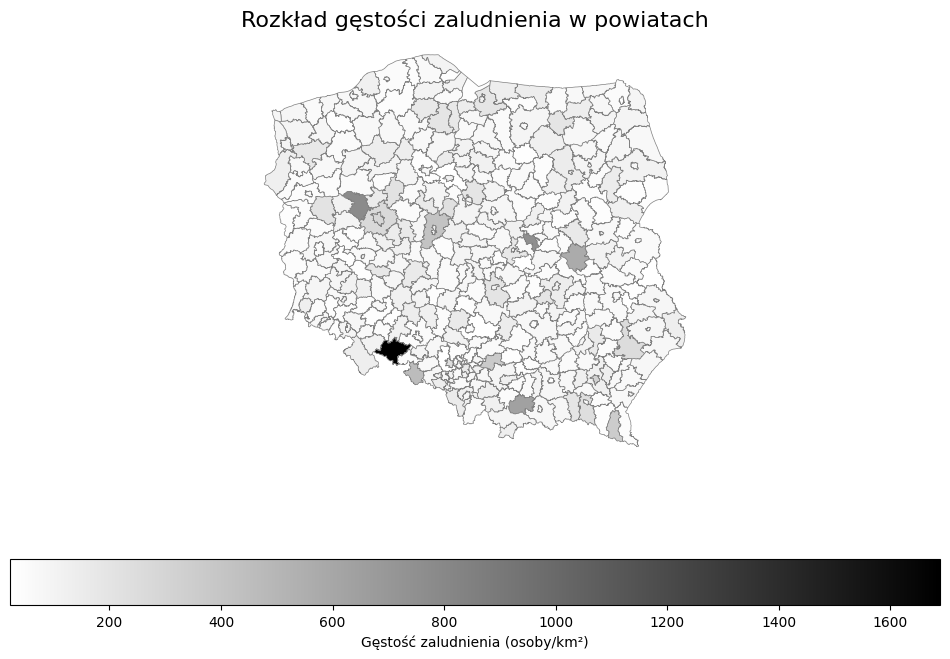

In [13]:
# Utworzenie wykresu z kolorami reprezentującymi gęstość zaludnienia
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

powiaty4.plot(
    column='Gęstość zaludnienia oraz wskaźniki|ludność w tysiącach',
    cmap='binary',
    edgecolor='gray',
    linewidth=0.5,
    legend=True,
    legend_kwds={
        'label': "Ludnośc w tysiącach",
        'orientation': "horizontal"
    },
    ax=ax
)

# Ustawienia dla mapy
ax.set_title('Rozkład gęstości zaludnienia w powiatach', fontsize=16)
ax.set_axis_off()

# Wyświetlenie mapy
plt.show()


In [ ]:
# Obliczenie centroidów dla każdego powiatu
powiaty4['centroid'] = powiaty4.geometry.centroid

In [ ]:
powiaty4.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 50 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   gml_id                                                  0 non-null      object  
 1   JPT_SJR_KO                                              379 non-null    object  
 2   JPT_POWIER                                              379 non-null    object  
 3   JPT_KOD_JE                                              379 non-null    object  
 4   JPT_NAZWA_                                              379 non-null    object  
 5   JPT_ORGAN_                                              0 non-null      object  
 6   JPT_JOR_ID                                              379 non-null    object  
 7   WERSJA_OD                                               379 non-null    object  
 8   WERSJA_DO             

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

# Funkcja do obliczania odległości w kilometrach
def haversine(point1, point2):
    lon1, lat1 = point1.x, point1.y
    lon2, lat2 = point2.x, point2.y
    # Promień Ziemi w kilometrach
    R = 6371.0
    # Konwersja stopni na radiany
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    # Obliczanie odległości
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Inicjalizacja macierzy odległości
num_powiaty = len(powiaty4)
distance_matrix = np.zeros((num_powiaty, num_powiaty))

# Wypełnienie macierzy odległości
for i, centroid_i in enumerate(powiaty4['centroid']):
    for j, centroid_j in enumerate(powiaty4['centroid']):
        if i != j:
            distance_matrix[i, j] = haversine(centroid_i, centroid_j)
        else:
            distance_matrix[i, j] = np.nan  # Odległość do samego siebie ustawiona jako NaN


In [ ]:

# Funkcja do obliczania potencjału
def calculate_potential(masses, distances, beta=1):
    potentials = np.zeros(len(masses))
    avg_distance = np.nanmean(distances)  # Średnia odległość dla wartości > 0

    for i in range(len(masses)):
        adjusted_distances = distances[i].copy()
        adjusted_distances[np.isnan(adjusted_distances)] = avg_distance  # Zastąp NaN średnią odległością
        potentials[i] = np.sum(masses / (adjusted_distances ** beta))
    return potentials


In [ ]:

# Wartości mas (np. gęstość zaludnienia)
masses = powiaty4['Gęstość zaludnienia oraz wskaźniki|ludność w tysiącach'].values

# Obliczenie potencjału dla każdego powiatu
beta = 1  # Parametr modelu
powiaty4['potential'] = calculate_potential(masses, distance_matrix, beta)



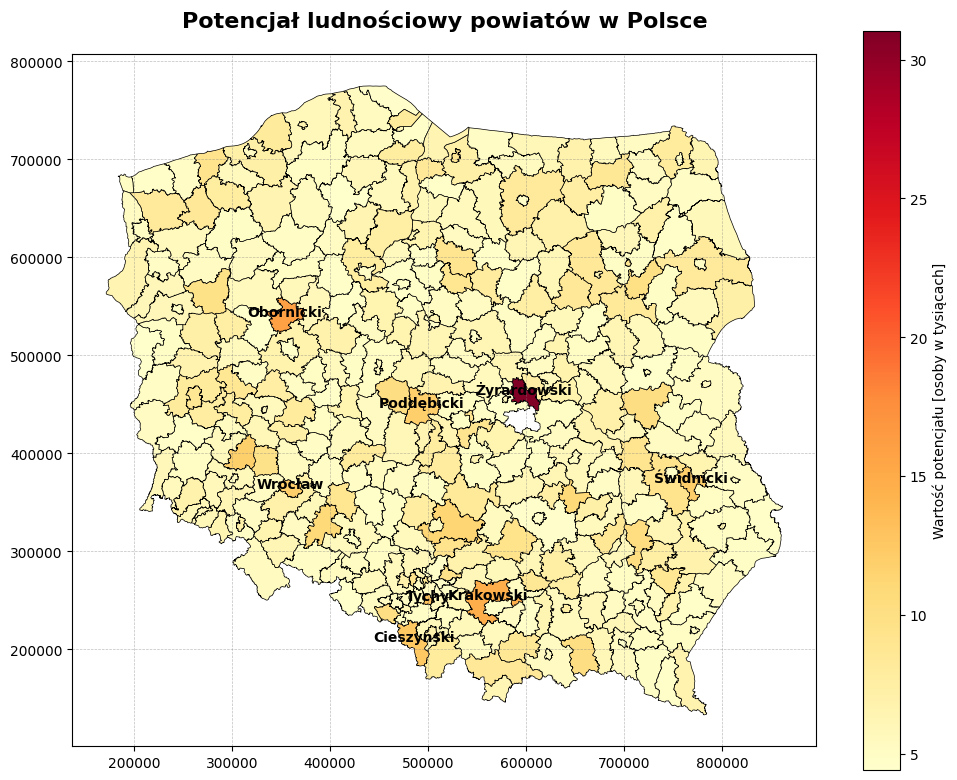

In [ ]:
# Utworzenie mapy z potencjałem
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
high_potential_threshold = np.percentile(powiaty4['potential'], 98)

# Rysowanie mapy
powiaty4.plot(
    column='potential',
    cmap='YlOrRd',  # Kontrastowa paleta kolorów
    linewidth=0.5,
    ax=ax,
    edgecolor='black',  # Dodanie wyraźnych granic powiatów
    legend=True,
    legend_kwds={
        'label': "Wartość potencjału [osoby w tysiącach]",
        'orientation': "vertical",
        'shrink': 0.8,  # Dostosowanie rozmiaru legendy
    },
)

# Dodanie tytułu
plt.title('Potencjał ludnościowy powiatów w Polsce', fontsize=16, fontweight='bold', pad=20)

# Dodanie siatki
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Dodanie etykiet tylko dla powiatów o wysokim potencjale
for x, y, label, name in zip(
    powiaty4.centroid.x,
    powiaty4.centroid.y,
    powiaty4['potential'],
    powiaty4['JPT_NAZWA_'].str.title()
):
    if label > high_potential_threshold:  # Warunek na dużą wartość potencjału
        ax.text(x, y, name, fontsize=10, ha='center', color='black', fontweight='bold')

# Wyświetlenie mapy
plt.show()

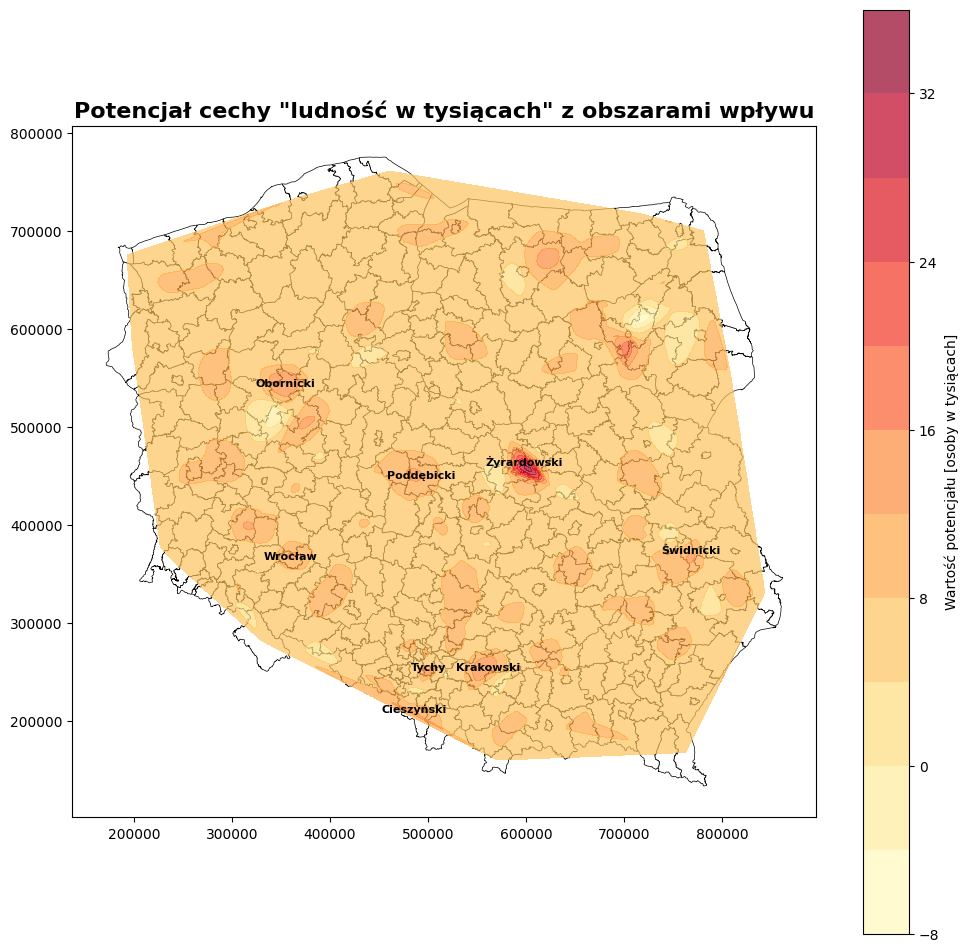

In [ ]:
# Obliczenie centroidów dla siatki potencjałów
potential = powiaty4['potential'].values
powiaty4['x'] = powiaty4.centroid.x
powiaty4['y'] = powiaty4.centroid.y
x = powiaty4['x'].values
y = powiaty4['y'].values

# Tworzenie siatki (grid) dla obszarów wpływu
xi, yi = np.linspace(x.min(), x.max(), 2000), np.linspace(y.min(), y.max(), 2000)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), potential, (xi, yi), method='cubic')

# Rysowanie mapy z obszarami wpływu
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
powiaty.plot(ax=ax, edgecolor='black', color='white', linewidth=0.5)  # Granice powiatów

# Dodanie obszarów wpływu (konturów)
contour = ax.contourf(xi, yi, zi, levels=10, cmap='YlOrRd', alpha=0.7)

# Dodanie legendy dla obszarów wpływu
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Wartość potencjału [osoby w tysiącach]")

# Dodanie nazw powiatów o wysokim potencjale
high_potential_threshold = np.percentile(potential, 98)
for px, py, pval, pname in zip(x, y, potential, powiaty4['JPT_NAZWA_'].str.title()):
    if pval > high_potential_threshold:
        ax.text(px, py, pname, fontsize=8, ha='center', color='black', fontweight='bold')

# Tytuł mapy
plt.title('Potencjał cechy "ludność w tysiącach" z obszarami wpływu', fontsize=16, fontweight='bold')
plt.show()


potencjal odpadow/potencjal ludnosci

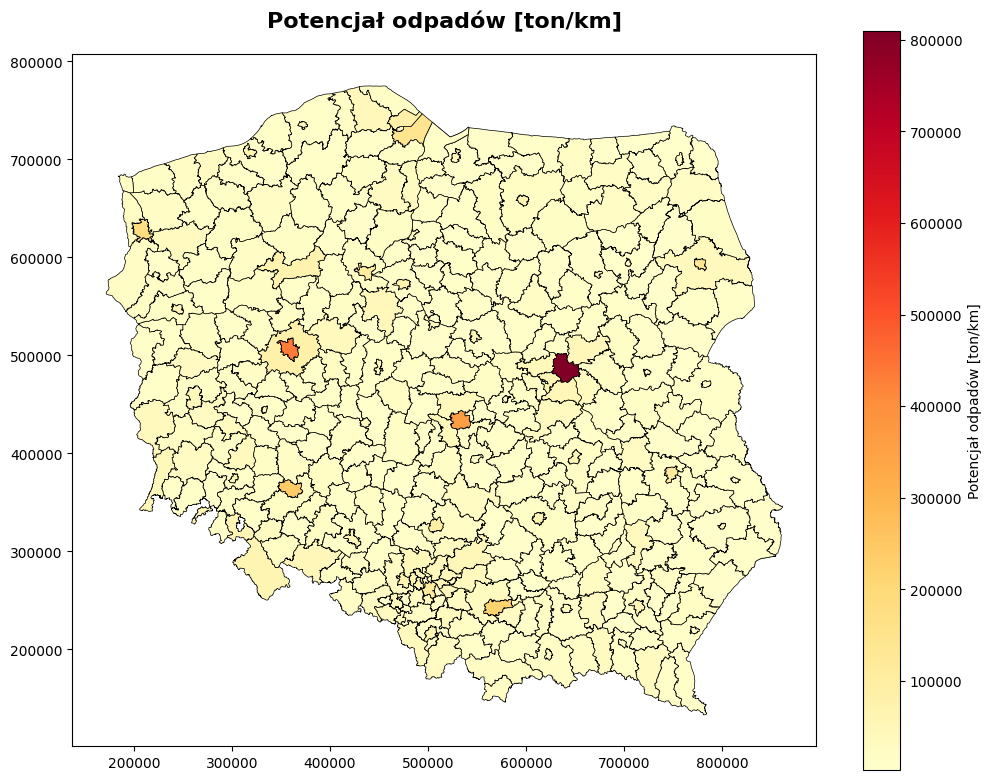

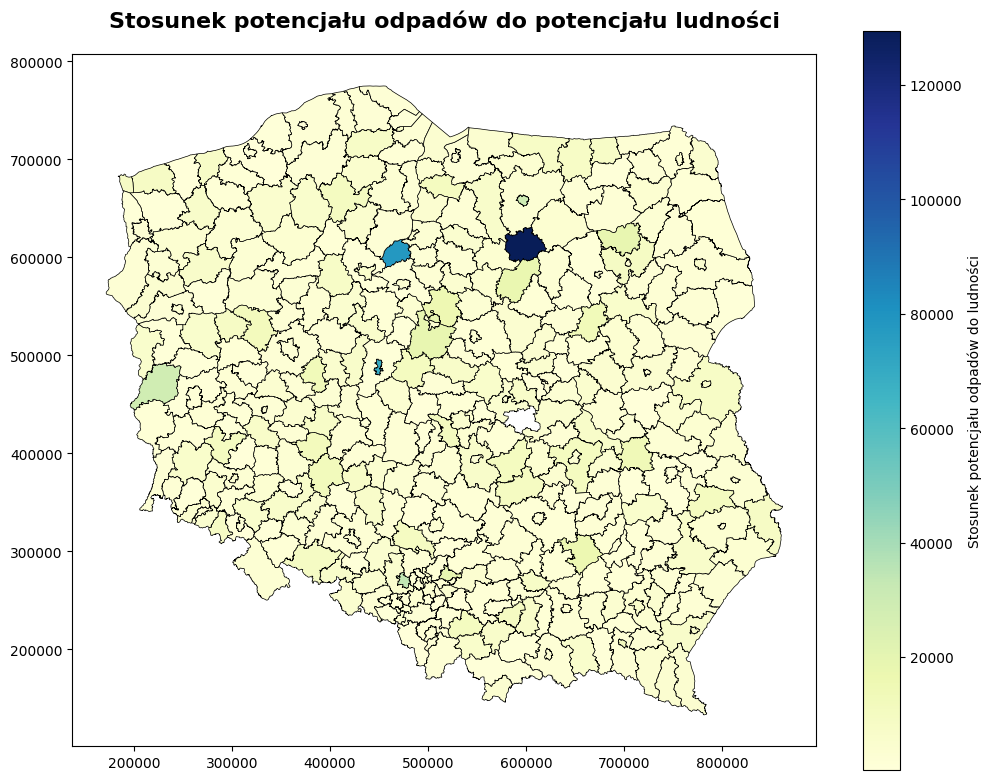

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Podział potencjału odpadów przez potencjał ludności
powiaty4['potential_ratio'] = powiaty3['potential'] / powiaty4['potential']

# Mapa 1: Potencjał odpadów bez modyfikacji
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
powiaty3.plot(
    column='potential',
    cmap='YlOrRd',
    linewidth=0.5,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={
        'label': "Potencjał odpadów [ton/km]",
        'orientation': "vertical",
        'shrink': 0.8,
    },
)
plt.title('Potencjał odpadów [ton/km]', fontsize=16, fontweight='bold', pad=20)
plt.show()

# Mapa 2: Stosunek potencjału odpadów do potencjału ludności
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
powiaty4.plot(
    column='potential_ratio',
    cmap='YlGnBu',
    linewidth=0.5,
    ax=ax,
    edgecolor='black',
    legend=True,
    legend_kwds={
        'label': "Stosunek potencjału odpadów do ludności",
        'orientation': "vertical",
        'shrink': 0.8,
    },
)
plt.title('Stosunek potencjału odpadów do potencjału ludności', fontsize=16, fontweight='bold', pad=20)
plt.show()